### **(?): shows where you need to write code**

### (?) Go to the location of the data

Mount the notebook to your google drive, and then you can access the files in google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**(?) Switch to the corona folder**

command: %cd /content/drive/MyDrive/.../corona

'...' means the path from 'MyDrive' to the 'corona' folder, which needs to be filled in according to where you put the 'corona' folder

In [2]:
%cd /content/drive/MyDrive/corona

/content/drive/MyDrive/corona


**Check if the directory is correct**

If correct, you will find "data", "corona_questions", and "corona.ipynb" in the output

In [3]:
!ls

corona.ipynb  data


### (?) (optional) Package

**Import packages**

In [4]:
import numpy as np
from scipy.io import loadmat, savemat

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from pathlib import Path
import math

import os
import time
import datetime
import matplotlib.pyplot as plt

import cv2

**(?) (optional) Other packages**

If you want to use some packages that are not imported above, please write in the block below; if not, you can ignore this block


### (?) Data

> In this project, the model is designed for complex-valued video, you need to read the file and treat it as a complex-valued video, whether it is a complex-valued video or a real-valued video, and then store it as real-valued data

> In the data folder, there are 9 MAT files, and each file has three 3D arrays of size (H,W,T<sub>total</sub>):
> * D: raw data, original video
> * L: low rank part, background
> * S: sparse part, foreground
>
> where H is the height of the frame, W is the width of the frame, and T<sub>total</sub> is the total number of frames in the video. Also, the frame size has been resized to 100*100 (meaning H = W = 100)

**(?) Read files and Get data**

Description: You already know the location of the files containing the videos, please read them and gather and organize the data. 

Requirements:
1. You need to sample a continuous segment of length T (num_frames in the code) from the video every few frames (stride in the code), each segment of size (H,W,T)
2. Because the model only accepts real-valued data, and the segment is complex-valued, it is necessary to concatenate the real and imaginary parts of the video along the third dimension.
 * Size changed from (H,W,T) to (H,W,T2), where T2 = T × 2, the first T 2D arrays are the real part of the segment, and the last T 2D arrays are the imaginary part of the segment
3. Function I/O
 * Input: A MAT file, num_frames, stride
 * Output: D, L, S (the size should be (N,1,H,W,T2), where N is the number of segments of size (H,W,T2))

Hint:
* Given a tensor A of size (H,W,T), what is the size of B = A[None, ...]?

In [5]:
mat_data = loadmat(Path.cwd()/'data'/'Snellen.mat')
complex_array = mat_data['S']
imaginary_values = complex_array.imag[np.nonzero(complex_array.imag)]
imaginary_values

array([], dtype=float64)

In [6]:
def get_data(file, num_frames=40, stride=10):
    Curr_mat = loadmat(file)
    D_mat = Curr_mat['D']
    L_mat = Curr_mat['L']
    S_mat = Curr_mat['S']
    H, W, T = D_mat.shape
    N = (T - num_frames) // stride + 1
    D = np.zeros((N, 1, H, W, num_frames))
    L = np.zeros((N, 1, H, W, num_frames))
    S = np.zeros((N, 1, H, W, num_frames))
    for i in range(0, T - num_frames + 1, stride):
        first_frame = i
        last_frame = i + num_frames
        index = i // stride
        D[index, 0, :, :, :] = D_mat[:, :, first_frame:last_frame]
        L[index, 0, :, :, :] = L_mat[:, :, first_frame:last_frame]      
        S[index, 0, :, :, :] = S_mat[:, :, first_frame:last_frame]
    return D, L, S


**(?) Build a custom dataset using the data you get from 'get_data'**

Requirement:
1. You now get D, L, S, please build a custom dataset for loading data

Note:
1. Image transformation is not necessary, it's up to you

In [18]:
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self , D , L , S):
    self.D = D
    self.L = L
    self.S = S

  def __len__(self):
    return self.D.shape[0]
    

  def __getitem__(self , index):
    return self.D[index] , self.L[index] , self.S[index]


### (?) Model

> You'll be writing code for soft thresholding in your model, so here's a brief description of what soft thresholding is and how to use it
>
> * Hard thresholding will turn values close to 0 directly to 0, while soft thresholding will move all values closer to 0 (too close will directly become 0)
>
> * Using a soft threshold with $ℓ_1$-norm can make variables sparse, in practice you can often see many people use it because $ℓ_1$-norm has good properties (convex, continuous, sub-differentiable)
> 
> * Suppose now you have a variable $x$ (scalar or vector) and a threshold $t \geq 0$, you can do soft thresholding on $x$ as follows:
>
>  1. Change $x = ||x||_2 × \frac{x}{||x||_2}$, the first part shows the magnitude and the second part shows the direction
>  2. We do the thresholding on the magnitude, so change the magnitude to ReLU$(||x||_2 - t)$
>  3. The result $x'=$ ReLU$(||x||_2 - t) × \frac{x}{||x||_2} = (||x||_2 - t)_{+} × \frac{x}{||x||_2}$
> * From the above example, you can find that the most important thing is to find an appropriate threshold $t$, which is what we want the model to learn
>

**(?) Complex Convolutional 3D Layer**

From the equation:

Y = X × W \\
= Y<sub>real</sub> + jY<sub>imag</sub>
= (X<sub>real</sub> + jX<sub>imag</sub>) × (W<sub>real</sub> + jW<sub>imag</sub>) \\
= X<sub>real</sub> × W<sub>real</sub> + X<sub>real</sub> × jW<sub>imag</sub> + jXi × W<sub>real</sub> + jX<sub>imag</sub> × jW<sub>imag</sub> \\
= (X<sub>real</sub> × W<sub>real</sub> - X<sub>imag</sub> × W<sub>imag</sub>) + j(X<sub>real</sub> × W<sub>imag</sub> + X<sub>imag</sub> × W<sub>real</sub>)

We can easily find out how to directly use the real and imaginary parts of the input and weight to get the correct result Y<sub>real</sub>, Y<sub>imag</sub> (all are real-valued)

Requirements:
* Please complete the forward function, note that X and Y are the same size

In [7]:
class Conv3dC(nn.Module):
    def __init__(self, kernel_size, stride=1, padding = 'same'):
        super(Conv3dC, self).__init__()
        
        self.conv3d = nn.Conv3d(1, 1, kernel_size, stride=stride, padding=padding)
        self.activation = nn.ReLU(inplace=True)
    
    def forward(self, x):
        y = self.conv3d(x)
        y = self.activation(y)
        return y

**Combination of three Complex Convolutional 3D Layers**

In [8]:
class Conv3dCx3(nn.Module):
  def __init__(self, kernel_size):
    super(Conv3dCx3, self).__init__()
    
    self.kernel_size = kernel_size
    
    self.convD = Conv3dC(kernel_size)
    self.convL = Conv3dC(kernel_size)
    self.convS = Conv3dC(kernel_size)
  
  def forward(self, X):
    D, L, S = X
    D = self.convD(D)
    L = self.convL(L)
    S = self.convS(S)
    return D + L + S

**(?) Singular Value Thresholding (SVT)**

Description:
* SVT is used to make the matrix low rank, the principle is to make the singular value sparse
* Learnable parameter: lambda_L
* Threshold: sigmoid(lambda_L) × coeff_L × maximum singular value
* Each segment (containing many frames) has a threshold
* Reshape input of size (N,1,H,W,T2) to (N,1,H×W,T2) and convert it to a complex-valued version of size (N,1,H×W,T), and do sigular value thresholding for each sample of size (H×W,T)

Requirements:
* Please complete the forward function

Hints:
* Convert the array to the complex-valued version before thresholding
* X and Y are the same size

In [23]:
class SVT(nn.Module):
    def __init__(self, coeff_L):
        super(SVT, self).__init__()
        
        self.coeff_L = coeff_L
        self.lambda_L = nn.Parameter(torch.zeros(1, requires_grad=True))
        
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
  
    def forward(self, X):
        N, dummy, H, W, T = X.shape
        X_complex = torch.reshape(X, (N, dummy, H , W, T))
        Y = torch.zeros_like(X_complex)

        for i in range(N):
            for j in range(T):
                X_slice = X_complex[i, 0, :, :, j]
                X_slice.isnan = 0
                U, S, VT = torch.linalg.svd(X_slice)
                threshold = self.sigmoid(self.lambda_L) * self.coeff_L * S.max()
                S_thresh = self.relu(S - threshold)
                S_thresh_diag = torch.diag(S_thresh)
                Y_slice = torch.matmul(torch.matmul(U, S_thresh_diag), VT)
                Y[i, 0, :, :, j] = Y_slice
              
        return Y


**(?) Soft Thresholding (SFT)**

Description:
* SFT is used to make the array sparse
* Learnable parameter: lambda_S
* Threshold: sigmoid(lambda_S) × coeff_S × (root) mean square of elements per frame
* Each frame has a threshold

Requirements:
* Please complete the forward function

Hints:
* Convert the array to the complex-valued version before thresholding
* X and Y are the same size

In [10]:
class SFT(nn.Module):
  def __init__(self, coeff_S):
    super(SFT, self).__init__()
    
    self.coeff_S = coeff_S
    self.lambda_S = nn.Parameter(torch.zeros(1, requires_grad=True))
    
    self.relu = nn.ReLU(inplace=True)
    self.sigmoid = nn.Sigmoid()
  
  def forward(self, X):
    #(?) Write code here
    N, tmp, H, W, T = X.shape

    for i in range(N):
      for f in range(T):
        frame = X[i, 0, :, :, f]
        threshold = self.sigmoid(self.lambda_S).item() * self.coeff_S * math.sqrt(torch.mean(torch.square(frame)))
        X[i, 0, :, :, f] = self.relu(torch.sub(frame, threshold))

    return X

  # staticmethod
  # def mean_square(frame):
  #   frame = frame
  #   ans = 0
  #   # numpy makes it faster
  #   for x in frame:
  #     for el in x:
  #       ans += el**2
  #   return math.sqrt(ans)

In [ ]:
X = torch.rand(3, 1, 5, 5, 4)
my_sft = SFT(coeff_S=0.4)
output = my_sft.forward(X)
output

tensor([[[[[8.5544e-01, 4.4421e-01, 3.7663e-01, 0.0000e+00],
           [5.7362e-01, 7.0207e-01, 1.5441e-01, 7.3787e-01],
           [3.4352e-01, 6.8920e-02, 6.6867e-01, 5.3635e-02],
           [8.0638e-01, 5.8152e-01, 3.7431e-01, 0.0000e+00],
           [5.1432e-01, 7.9977e-02, 8.3311e-01, 7.9757e-01]],

          [[4.8638e-02, 0.0000e+00, 4.1449e-01, 1.5763e-01],
           [3.0324e-01, 7.5485e-01, 6.8056e-01, 1.4988e-01],
           [0.0000e+00, 7.3062e-01, 3.3568e-01, 3.2369e-01],
           [1.9355e-01, 3.2565e-02, 7.6285e-02, 3.5240e-01],
           [6.6064e-01, 6.8010e-02, 1.0506e-01, 4.6743e-01]],

          [[6.3155e-01, 0.0000e+00, 0.0000e+00, 1.0761e-01],
           [1.4113e-02, 8.0574e-01, 5.5836e-01, 8.8596e-01],
           [2.7493e-03, 2.5769e-02, 3.3780e-01, 7.5230e-01],
           [7.9755e-01, 8.4545e-02, 1.9301e-01, 2.3955e-01],
           [1.1287e-01, 7.9002e-01, 1.4168e-01, 5.3255e-01]],

          [[8.4809e-01, 1.9492e-01, 1.8263e-02, 2.4521e-01],
           [7.9304

**ISTA Cell**

Including Conv3dx3, SVT, SFT

In [11]:
class ISTACell(nn.Module):
  def __init__(self, kernel_size, coeff_L, coeff_S):
    super(ISTACell, self).__init__()
    
    self.kernel_size = kernel_size
    self.coeff_L = coeff_L
    self.coeff_S = coeff_S
    
    self.netL = nn.Sequential( Conv3dCx3(kernel_size), SVT(coeff_L) )
    self.netS = nn.Sequential( Conv3dCx3(kernel_size), SFT(coeff_S) )
  
  def forward(self, X):
    D = X[0]
    L = self.netL(X)
    S = self.netS(X)
    
    Y = torch.zeros(X.shape).to(X.device)
    Y[0], Y[1], Y[2] = D, L, S
    return Y

**(?) Deep Network: Convolutional rObust pRincipal cOmpoNent Analysis (CORONA)**

Description:
* kernel_list contains some integers, each integer k can be used to set the kernel_size = [k,k,1] of the corresponding layer

Requirement:
* Construct the network called 'net'

Hint:
* Please read ISTACell cell first
* You may need 'nn.Sequential(*layers)'

In [12]:
class CORONA(nn.Module):
    def __init__(self, kernel_list, coeff_L = 0.4, coeff_S = 1.8):
        super(CORONA, self).__init__()

        self.kernel_list = kernel_list
        self.coeff_L = coeff_L
        self.coeff_S = coeff_S

        layers = []
        for kernel_size in kernel_list:
            layers.append(ISTACell(kernel_size, coeff_L, coeff_S))

        self.net = nn.Sequential(*layers)

    def forward(self, D):
        X = torch.zeros([3] + list(D.shape)).to(D.device)
        X[0] = D
        X = self.net(X)
        L, S = X[1], X[2]
        return L, S

### Compute loss

Input:
* target = (target_L, target_S)

In [13]:
def get_loss(net, input_D, target, alpha=0.5):
  output_L, output_S = net(input_D.cuda())
  L , S = torch.split(target, target.shape[0] // 2, dim=0)
  target_L, target_S = L , S
  
  criterion = nn.MSELoss()

  loss_L = criterion(output_L, target_L)
  loss_S = criterion(output_S, target_S)
  loss = alpha * loss_L + (1-alpha) * loss_S
  
  return loss

### Function for constructing videos

Input:
* images_array is of size (H,W,T)

In [14]:
def array_to_gray_video(images_array, video_name, fps=30):
  # Get the height and width of the video, assuming all frames have the same size
  height, width = images_array.shape[0], images_array.shape[1]

  # Set the video codec to mp4
  fourcc = cv2.VideoWriter_fourcc(*"mp4v")

  # Create a VideoWriter object, with parameters for the output file name, codec, frame rate, and size
  video = cv2.VideoWriter(video_name, fourcc, fps, (width, height), isColor=False)

  # Write each frame in the numpy array to the output video
  for i in range(images_array.shape[2]):
    image = images_array[:,:,i]
    image = np.uint8(image) # Convert to uint8 format
    video.write(image)

  # Release the resources used by the VideoWriter and destroy any OpenCV windows
  video.release()
  cv2.destroyAllWindows()

### (?) Main

Decide which device to use

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
torch.cuda.is_available()

True

**(?) Get data**

Requirements:
* Get data from the files and concatenate them
* Build datasets and dataloaders

In [19]:
# Collect files in the data folder
path = Path.cwd()
data_folder = path/'data'
file_list = os.listdir(data_folder)

# Initialize empty lists for D, L, and S
D_list = []
L_list = []
S_list = []

# Process each file in file_list
for file_name in file_list:
    # Get data from the file
    D, L, S = get_data(os.path.join(data_folder, file_name))
    print(f'file {file_name}')
    
    # Append D, L, and S to the respective lists
    D_list.append(D)
    L_list.append(L)
    S_list.append(S)
    

# Concatenate D, L, and S along the first dimension
D = np.concatenate(D_list, axis=0, dtype=np.float32)
L = np.concatenate(L_list, axis=0, dtype=np.float32)
S = np.concatenate(S_list, axis=0, dtype=np.float32)

# Create a custom dataset using the obtained arrays
dataset = CustomDataset(D, L, S)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_set, valid_set = random_split(dataset, [train_size, valid_size])

# Create data loaders for training and validation
batch_size = 4
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

file IBMtest2.mat
file CaVignal.mat
file Board.mat
file HighwayII.mat
file HallAndMonitor.mat
file Snellen.mat
file HighwayI.mat
file Candela_m1.mat
file CAVIAR1.mat


Create a model

In [24]:
kernel_list = [5]*3
coeff_L = 0.4
coeff_S = 1.8
net = CORONA(kernel_list, coeff_L=coeff_L, coeff_S=coeff_S)
net = net.to('cuda')

**(?) Train the model**

Requirements:
* Determine the optimizer
* Finish the training process

Note:
* It takes about 2 hours to complete 100 epochs, you can test it with smaller max_epochs to confirm whether the code is correct

In [ ]:
loss_list = np.array([])
lr_list = np.array([])
train_loader_lr = DataLoader(train_set, batch_size = 2 * batch_size, shuffle=True)
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

for epoch in range(3):
  print(f'epoch num {epoch}')
  for i , batch in enumerate(train_loader_lr):
    print(i , len(batch) , len(train_loader_lr))
    D , L , S = batch
    D = D.to('cuda')
    target = torch.cat((L , S) , dim = 0).to('cuda')
    optimizer.zero_grad()
    loss = get_loss(net , D , target, alpha = 0.5)
    loss.backward()
    optimizer.step()
  loss_list = np.append(loss_list , (loss / len(train_loader_lr)).cpu().detach().numpy())
  lr_scheduler.step()
  lr_list = np.append(lr_list, optimizer.param_groups[0]['lr'])

min_loss_idx = np.argmin(loss_list)
opt_lr = lr_list[min_loss_idx]

epoch num 0
0 3 11
1 3 11
2 3 11
3 3 11
4 3 11
5 3 11
6 3 11
7 3 11
8 3 11
9 3 11
10 3 11
epoch num 1
0 3 11
1 3 11
2 3 11
3 3 11
4 3 11
5 3 11
6 3 11
7 3 11
8 3 11
9 3 11
10 3 11
epoch num 2
0 3 11
1 3 11
2 3 11
3 3 11
4 3 11
5 3 11
6 3 11
7 3 11
8 3 11
9 3 11
10 3 11


In [ ]:
print(lr_list)
print(opt_lr)

[0.01   0.001  0.0001]
0.010000000000000002


In [25]:
max_epochs = 50
alpha = 0.5

#(?) Optimizer
optimizer = torch.optim.SGD(net.parameters() , lr=0.01)

# 
min_valid_loss = np.inf

# Container of the results
train_loss_list = np.empty([0])
valid_loss_list = np.empty([0])
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
lr_list = np.empty([0])

for epoch in range(max_epochs):
  #(?) Use 'train_loader' to update the model
  
  print(f'epoch #{epoch}')
  train_loss = 0
  for i , batch in enumerate(train_loader):
    D , L , S = batch
    D = D.to('cuda')
    target = torch.cat((L , S) , dim = 0).to('cuda')
    optimizer.zero_grad()
    loss = get_loss(net, D, target, alpha)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  train_loss_list = np.append(train_loss_list, train_loss / len(train_loader))

  valid_loss = 0
  for i, batch in enumerate(valid_loader):
    D, L, S = batch
    D = D.to('cuda')
    target = torch.cat((L, S), dim=0).to('cuda')
    loss = get_loss(net, D, target, alpha=alpha)
    valid_loss += loss.item()
  valid_loss_list = np.append(valid_loss_list, valid_loss / len(valid_loader))

  #(?) Use 'train_loader' and 'valid_loader' to evaluate the model
  #   Compute train_loss and valid_loss and append them to train_loss_list and valid_loss_list respectively

  # Use validation loss to determine the best model
  if valid_loss < min_valid_loss:
    net_best = net
    min_valid_loss = valid_loss

net = net_best

epoch #0
epoch #1
epoch #2
epoch #3
epoch #4
epoch #5
epoch #6
epoch #7
epoch #8
epoch #9
epoch #10
epoch #11
epoch #12
epoch #13
epoch #14
epoch #15
epoch #16
epoch #17
epoch #18
epoch #19
epoch #20
epoch #21
epoch #22
epoch #23
epoch #24
epoch #25
epoch #26
epoch #27
epoch #28
epoch #29
epoch #30
epoch #31
epoch #32
epoch #33
epoch #34
epoch #35
epoch #36
epoch #37
epoch #38
epoch #39
epoch #40
epoch #41
epoch #42
epoch #43
epoch #44
epoch #45
epoch #46
epoch #47
epoch #48
epoch #49


**(?) Save the model and the results**

Requirements:
* Create a folder
* Save the model (net) and results (training/validation loss list) to the folder

Hint:
* You can use 'Path().mkdir()' to create a folder
* You can use 'torch.save' to save the model
* You use 'np.savez' to save the results

In [26]:
# Create a folder to save the model and results
save_folder = "saved_model"
Path(save_folder).mkdir(parents=True, exist_ok=True)

# Save the model
torch.save(net.state_dict(), save_folder + "/model.pth")

# Save the results (training/validation loss list)
np.savez(save_folder + "/results.npz", training_loss=train_loss_list, validation_loss=valid_loss_list)

**(?) Plot the figures**

Requirements:
* Create a folder called 'fig_folder' and save the figure in this folder

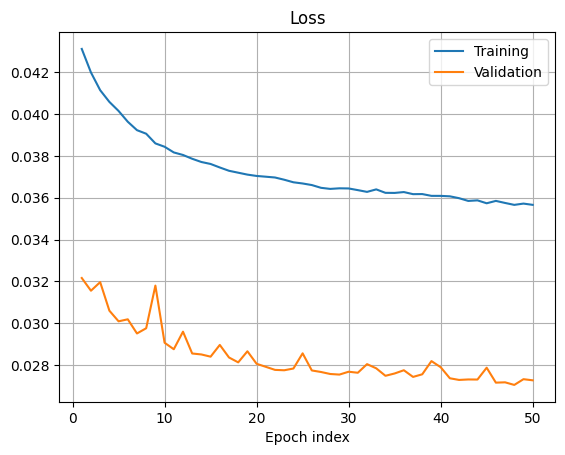

In [27]:
# Create a folder called 'fig_folder'
fig_folder = "fig_folder"
Path(fig_folder).mkdir(parents=True, exist_ok=True)

# 
num_epochs = train_loss_list.size
x_range = np.arange(num_epochs)+1

# Plot training/validation loss
plt.figure()
plt.plot(x_range, train_loss_list, label='Training')
plt.plot(x_range, valid_loss_list, label='Validation')
plt.title('Loss')
plt.xlabel('Epoch index')
plt.legend()
plt.grid()

# Save the loss curves figure
plt.savefig(fig_folder + "/loss_curves.png")

**(?) Get the videos**

Requirements:
* Create a folder called 'pred_folder' and save the predictions in this folder
* Create a folder called 'video_folder' and save the videos in this folder

In [32]:
#(?) Create 'pred_folder' and 'video_folder'
data_dir = Path.cwd()/'data'
pred_folder = 'pred_folder'
video_folder = 'video_folder'

if not os.path.exists(pred_folder):
    os.mkdir(pred_folder)

if not os.path.exists(video_folder):
    os.mkdir(video_folder)
# (Path.cwd() / pred_folder).mkdir(parents=True, exist_ok=True)
# (Path.cwd() / video_folder).mkdir(parents=True, exist_ok=True)

#

num_frames = 40
for file in file_list:
  D = loadmat(data_dir/file)['D']
  D = torch.from_numpy(D).cfloat()
  L = torch.empty(0)
  S = torch.empty(0)
  for k in range(0, D.shape[-1]-num_frames+1, num_frames):
    Dk = D[None, None, :, :, k:k+num_frames]
    Dk = torch.cat([torch.real(Dk), torch.imag(Dk)], dim=-1)
    Dk = Dk.to(device)
    
    with torch.no_grad():
      net.eval()
      Lk, Sk = net(Dk)

    Lk = Lk[..., :num_frames].cpu().detach().squeeze()
    Sk = Sk[..., :num_frames].cpu().detach().squeeze()
    
    L = torch.cat([L, Lk], dim=-1)
    S = torch.cat([S, Sk], dim=-1)
  
  savemat('%s/prediction_%s'%(pred_folder, file), {'L': L.numpy(), 'S': S.numpy()})

  D = torch.real(D[..., :L.shape[-1]])
  V = np.round(torch.cat([D, L, S], dim=1).numpy() * 255)
  array_to_gray_video(V, '%s/video_%s.mp4'%(video_folder, file[:-4]), fps=30)